# Quantum Computing Mentorship - Screening task

Here, I am presenting a solution to Task 2.

## Task 2

Implement a circuit that returns $|01\rangle$ and $|10\rangle$ with equal probability.

Requirements :
* The circuit should consist only of CNOTs, RXs and RYs. 
* Start from all parameters in parametric gates being equal to 0 or randomly chosen. 
* You should find the right set of parameters using gradient descent (you can use more advanced optimization methods if you like). 
* Simulations must be done with sampling - i.e. a limited number of measurements per iteration and noise. 

Compare the results for different numbers of measurements: 1, 10, 100, 1000. 

***Bonus question***: How to make sure you produce state $|01\rangle$ + $|10\rangle$ and not $|01\rangle$ - $|10\rangle$?


## Step 1: Install dependencies using requirements

## Step 2: Import the necessary libraries and setup

I use Qiskit for this solution. The backend I use `qasm_simulator` has noise.

In [76]:
import numpy as np
import random

from qiskit import(
  QuantumCircuit,
  execute,
  Aer)
from qiskit.visualization import plot_histogram

import matplotlib.pyplot as plt

In [77]:
# Use Aer's qasm_simulator
simulator = Aer.get_backend('qasm_simulator')
backend = Aer.get_backend('statevector_simulator')

np.set_printoptions(precision=10)
measurement_shots = [1000, 100, 10, 1]

## Step 3: Study circuit

Using a universal gate set, to implement a circuit that returns $|01\rangle$ and $|10\rangle$ with equal probability, we use the gates Hadamard, X, CNOT.

* We start from the state       $|00\rangle$
* Applying X gate to Qubit 2:   $|01\rangle$
* Applying H gate to Qubit 1:   $\frac{(|0\rangle + |1\rangle)}{\sqrt{2}}|1\rangle$
* Applying CNOT with control qubit 1 and target qubit 2: $\frac{|01\rangle + |10\rangle}{\sqrt{2}}$


Hence on measuring this, we would get a circuit that returns $|01\rangle$ and $|10\rangle$ with equal probability $\frac{1}{2}$

The circuit would look like: <img src="images/circuit.png">


#### Now we try to obtain a circuit that returns $|01\rangle$ and $|10\rangle$ with equal probability using Rx, Ry and CNOT gates:

* X gate can be written as Ry($\pi$) gate
* Next part of the circuit has to be an implementation that returns $|0\rangle$ and $|1\rangle$ with equal probability when applied on $|0\rangle$ state. Note that here, it is not necessry to recreate a Hadamard gate, as there can be multiple states with different phases which would returns $|00\rangle$ and $|11\rangle$ with $\frac{1}{2}$ probability.
* Finally we apply a CNOT gate for the result.


For the second part, when applied to $|0\rangle$ state would result in $|0\rangle$ and $|1\rangle$ with equal probability:
* Combination like Ry$(\pi/2)$Rx($\pi/2)$ would result in state $\frac{|0\rangle + |1\rangle}{\sqrt{2}}$
* Combination like Ry$(3\pi/2)$Rx($\pi/2)$ would result in state $\frac{|0\rangle - |1\rangle}{\sqrt{2}}$
* Combination like Ry$(3\pi/2)$Rx($3\pi/2)$ would result in state $\frac{|0\rangle - |1\rangle}{\sqrt{2}}$
* Combination like Ry$(\pi/2)$Rx($3\pi/2)$ would result in state $\frac{|0\rangle + |1\rangle}{\sqrt{2}}$

**Note**: We first implement a circuit that returns $|01\rangle$ and $|10\rangle$ with equal probability and we let the state be both $|01\rangle$ + $|10\rangle$ and $|01\rangle$ - $|10\rangle$. Next we present the solution to the bonus question where we ensure that the state is $|01\rangle$ + $|10\rangle$ and not $|01\rangle$ - $|10\rangle$


In [78]:
# Trial circuit
circuit = QuantumCircuit(2)

# X gate on qubit 1
circuit.ry(np.pi,1)

# H gate on qubit 0
circuit.ry(np.pi/2,0)
circuit.rx(np.pi/2,0)

# CNOT gate with qubit 0 as a control qubit and qubit 1 as the targer qubit
circuit.cx(0,1)

circuit.draw()

┌──────────┐┌──────────┐     
q_0: ┤ RY(pi/2) ├┤ RX(pi/2) ├──■──
     └┬────────┬┘└──────────┘┌─┴─┐
q_1: ─┤ RY(pi) ├─────────────┤ X ├
      └────────┘             └───┘

In [79]:
# Using a noiseless simulator

result = execute(circuit, backend, shots=1000).result()
result_counts  = result.get_counts() 
print("Probability of states: ", result_counts)

Probability of states:  {'01': 0.5, '10': 0.5}


## Step 4: Implement gradient descent

Gradient descent is a first-order iterative optimization algorithm for finding a local minimum of a differentiable function. Here, the gradient descent function will take the objective function as an input and tries to find the parameters at which this function will be minimum.


First we set the parameters of the gradient descent as following:
* Learning rate = 0.8
* Step size (h) = 0.005
* max_iteration = 1000
* momentum_coeff = 0.75


### Calculate gradient of an objective function

Here, I am using an analytical method to calculate the gradient of our objective function. For example, for a small value ```h```:

* We update theta as $\theta = \theta + h$
* Derivation of function $F(\theta)$ can be analytically written as ```gradient``` = $F'(\theta) = \frac{F(\theta + h)- F(\theta)}{h}$


### Update method in gradient descent

Using this gradient calucation methon, we update our parameter in every iteration using: ```param = param + learning_rate(gradient*momentum_coeff + (1-momentum_coeff)momentum)```

Here we use momentum to give some weightage to the gradient in the previous iteration as well.

In [80]:
# Set the parameters to perform gradient descent:

learning_rate = 0.8
step_size = 0.005
max_iteration = 1000
momentum_coeff = 0.75

In [81]:
# Some Helper functions

def get_measurement_results(circuit, shots):
    """
    This function takes circuit and number of measurement shots
    as the input and outputs the counts of measurement
    """
    
    circuit.measure_all()
    # The simulator used here 'qasm_simulator' has noise
    result = execute(circuit, simulator, shots=shots).result()
    result_counts  = result.get_counts(circuit)
    return result_counts


def get_state_vector(circuit):
    """
    This function takes computes the circuit and gets the statevector
    """
    final_state = execute(circuit, backend).result().get_statevector()
    
    return final_state


def get_probability_from_measurement_results(count, measurement_shots):
    """
    This function takes in counts from a measurement of a single qubit state
    and outputs the probabilty of measuring either state |0> or |1>
    """
    
    measure_0 = 0
    measure_1 = 0
    
    if '0' in count.keys():
        measure_0 = int(count['0'])/measurement_shots
    if '1' in count.keys():
        measure_1 = int(count['1'])/measurement_shots  
        
    return  measure_0, measure_1


def get_probability_from_measurement_results_2_qubits(
        count, measurement_shots):
    """
    This function takes in counts from a measurement of a two qubit state
    and outputs the probabilty of measuring either state |00>, |01>, |10> or |11>
    """
    
    measure_00 = 0
    measure_01 = 0
    measure_10 = 0
    measure_11 = 0
    
    if '00' in count.keys():
        measure_00 = int(count['00'])/measurement_shots
    if '01' in count.keys():
        measure_01 = int(count['01'])/measurement_shots
    if '10' in count.keys():
        measure_10 = int(count['10'])/measurement_shots
    if '11' in count.keys():
        measure_11 = int(count['11'])/measurement_shots
        
    return  measure_00, measure_01, measure_10, measure_11
        
    
def set_up_initial_params(number_of_gates):
    """
    This function generates random parameters for a give number of gates
    """
    
    params = []
    for j in range(number_of_gates):
        random_param = random.uniform(0, 2*np.pi)
        params.append(random_param)
        
    return params


def pretty_print_results(iteration, obj_value, param):
    print("Number of iterations: ", iteration)     
    print("Minimum distance: ", obj_value, "Value of parameter: ", param)
    print("_________________________________________________________")

In [82]:
def calculate_gradient(
    j, objective_function, params, obj_value, measurement_shots):
    """
    This function analytically calculates the gradient of any objective_function
    * We update theta as 𝜃=𝜃+ℎ 
    * Derivation of function 𝐹'(𝜃) = (𝐹(𝜃+ℎ)−𝐹(𝜃))/ℎ
    """
    update_params = params.copy()
    
    update_params[j] = params[j] + step_size
    update_obj_value   = objective_function(
        update_params, measurement_shots)
    
    gradient_value = (update_obj_value  - obj_value)/step_size
    return gradient_value


def update_param(j, params, gradient_value_arr, momentum_arr):
    """
    This function updates the parameter according its gradient value
    and previous momentum
    
    * param = param + learning_rate(gradient*momentum_coeff + (1-momentum_coeff)momentum)
    """
    
    params[j] -= learning_rate*(
              gradient_value_arr[j]*momentum_coeff + (1-momentum_coeff)*momentum_arr[j])
    params[j] =  params[j] % (2*np.pi)
    
    return params[j]


def perform_gradient_descent(
    initial_params, objective_function, measurement_shots=None, disp = False): 
    """
    This function analytically performs the gradient descent by taking
    an objective function as an input and finding the parameter for
    which this function is minimum
    """
    
    # Select parameters initially at random
    params = np.array(initial_params).copy()
    number_of_gates = len(initial_params)
    
    min_params = np.array(params).copy()
    obj_value = objective_function(params, measurement_shots)
    min_obj_value = obj_value 
    
    for iteration in range(max_iteration): 
       
       # Find the gradient value for all parameters
       gradient_value_arr = []
       for j in range(number_of_gates):
          gradient_value = calculate_gradient(
              j, 
              objective_function,
              params,
              obj_value,
              measurement_shots)
          gradient_value_arr.append(gradient_value) 
        
       # Setup a momentum for the previous gradient value 
       if (iteration == 0):
          momentum_arr = gradient_value_arr
       
       # Update the parameters according to their gradient and momentum
       for j in range(number_of_gates): 
          params[j] = update_param(j, params, gradient_value_arr, momentum_arr)
            
       momentum_arr = gradient_value_arr
    
       #Find the update value of objective function
       obj_value   = objective_function(params, measurement_shots)
    
       if disp:
           print("\niteration: ", iteration, " obj_value: ", obj_value, " param: ", params)
       
       if (obj_value == 0):
           # We do this because we want to want the final optimised value 
           min_obj_value = obj_value
           min_params = np.array(params).copy()
        
       if (min_obj_value > obj_value):
           min_obj_value = obj_value
           min_params = np.array(params).copy()

    pretty_print_results(max_iteration, min_obj_value, min_params)
    return {"min_trace_norm": min_obj_value , "min_params": min_params}

## Step 5: Use Gradient descent to find representation of X gate

Here we first define our objective function which has to be minimised.

**Objective function**: (prob$[0]$ - 0)$^2$ + (prob$[1]$ - 1)$^2$

* prob$[0]$: probability to measure the state $|0\rangle$
* prob$[1]$: probability to measure the state $|1\rangle$

For a perfect X gate, the value of this objective function would be 0, hence we try to minimise this objective function.

In [83]:
def objective_function_for_X_gate(params, measurement_shots):
    circuit = QuantumCircuit(1)
    
    # X gate on qubit 1
    circuit.ry(params[0], 0)
    
    count = get_measurement_results(
        circuit, measurement_shots)
    measurement_probability = get_probability_from_measurement_results(
        count, measurement_shots)
 
    obj_val = ((float(measurement_probability[0]) - 0)**2
               + (float(measurement_probability[1]) - 1)**2)
    return obj_val 


number_of_gates = 1
initial_params = set_up_initial_params(number_of_gates)
print("Initial param: ", initial_params[0])

x_gate_results = []

for i in range(4):
    print("\nResult with number of measurement shots: ", measurement_shots[i])
    
    result = perform_gradient_descent(
        initial_params, objective_function_for_X_gate, measurement_shots[i])
    x_gate_results.append(result)

Initial param:  2.249597298283407

Result with number of measurement shots:  1000
Number of iterations:  1000
Minimum distance:  0.0 Value of parameter:  [3.1614879126]
_________________________________________________________

Result with number of measurement shots:  100
Number of iterations:  1000
Minimum distance:  0.0 Value of parameter:  [3.1375972983]
_________________________________________________________

Result with number of measurement shots:  10
Number of iterations:  1000
Minimum distance:  0.0 Value of parameter:  [2.9504854552]
_________________________________________________________

Result with number of measurement shots:  1
Number of iterations:  1000
Minimum distance:  0.0 Value of parameter:  [4.5502443004]
_________________________________________________________


## Step 6: Use Gradient descent to find representation for a circuit that returns $|00\rangle$  and  $|11\rangle$  with equal probability.

**Note**: We first implement a circuit that returns $|01\rangle$ and $|10\rangle$ with equal probability and we let the state be both $|01\rangle$ + $|10\rangle$ and $|01\rangle$ - $|10\rangle$ in this objective function.

**Objective function**: (prob$[0]$ - $\frac{1}{2})^2$ + (prob$[1]$ - $\frac{1}{2})^2$

* prob$[0]$: probability to measure the state $|0\rangle$
* prob$[1]$: probability to measure the state $|1\rangle$

For a perfect implementation of $|00\rangle$  and  $|11\rangle$  with equal probability, this objective function would be equal to 0

In [84]:
def objective_function_for_equal_prob(params, measurement_shots):
    circuit = QuantumCircuit(1)
    
    circuit.ry(params[0],0)
    circuit.rx(params[1],0)

    count = get_measurement_results(circuit, measurement_shots)
    measurement_probability = get_probability_from_measurement_results(
        count, measurement_shots)
    
    obj_val = ((float(measurement_probability[0]) - 0.5)**2
               + (float(measurement_probability[1]) - 0.5)**2)
    return obj_val


number_of_gates = 2
initial_params = set_up_initial_params(number_of_gates)
print("Initial param: ", initial_params)

equal_prob_results = []

for i in range(4):
    print("\nResult with number of measurement shots: ", measurement_shots[i])
    
    result = perform_gradient_descent(
        initial_params, objective_function_for_equal_prob, measurement_shots[i])
    equal_prob_results.append(result)

Initial param:  [2.905554460156668, 5.525941875401422]

Result with number of measurement shots:  1000
Number of iterations:  1000
Minimum distance:  0.0 Value of parameter:  [5.228850774  4.8099385816]
_________________________________________________________

Result with number of measurement shots:  100
Number of iterations:  1000
Minimum distance:  0.0 Value of parameter:  [5.6542825135 4.6930471308]
_________________________________________________________

Result with number of measurement shots:  10
Number of iterations:  1000
Minimum distance:  0.0 Value of parameter:  [6.148065415 4.47460964 ]
_________________________________________________________

Result with number of measurement shots:  1
Number of iterations:  1000
Minimum distance:  0.5 Value of parameter:  [2.9055544602 5.5259418754]
_________________________________________________________


## Step 7: Presenting results

Here, we first take all the parameters we obtained by performing gradient descent on parameters on the different part of the circuit, and form a new circuit using that. 

* We first apply the parametric gate for X gate to qubit 1
* Then we apply the parametric gates which results in $|00\rangle$  and  $|11\rangle$  with equal probability to qubit 0
* Then we apply CNOT gate with qubit 0 as a control qubit and qubit 1 as the targer qubit

Then we measure the circuit using the particular number of shots we used earlier in gradient descent. Next we present the result using Histograms for the number of shots: 1000, 100, 10, 1.

**Note: Here we observe that as the number of shots decrease, the error percent in our result increases.**


In [85]:
def checking_results(x_gate_results, equal_prob_results):
    """
    This function takes all the paramters we obtain from the gradient descent for 
    X gate and H gate and applies to a new circuit.
    
    We then measure this new circuit with different measurement shots
    """
    
    counts = []
    obj_values = []
    
    for i in range(4):    
        circuit = QuantumCircuit(2)

        # X gate on qubit 1
        circuit.ry(x_gate_results[i]['min_params'][0],1)

        # H gate on qubit 0
        circuit.ry(equal_prob_results[i]['min_params'][0],0)
        circuit.rx(equal_prob_results[i]['min_params'][1],0)

        # CNOT gate with qubit 0 as a control qubit and qubit 1 as the targer qubit
        circuit.cx(0,1)
        count = get_measurement_results(circuit, measurement_shots[i])
        counts.append(count)
        
        prob = get_probability_from_measurement_results_2_qubits(
        count, measurement_shots[i])
        
        
        obj_val = ((float(prob[0]) - 0)**2 + (float(prob[1]) - 0.5)**2
                + (float(prob[2]) - 0.5)**2 + (float(prob[3]) - 0)**2)
        obj_values.append(obj_val)         
    return counts, obj_values
        
counts, obj_values = checking_results(x_gate_results, equal_prob_results)

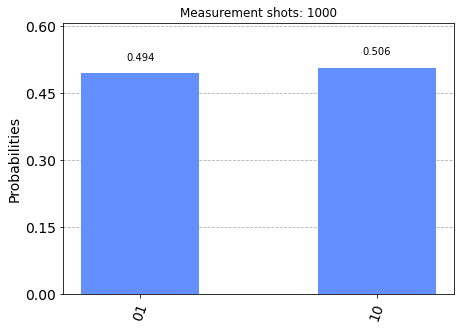

In [86]:
plot_histogram(counts[0], title="Measurement shots: 1000")

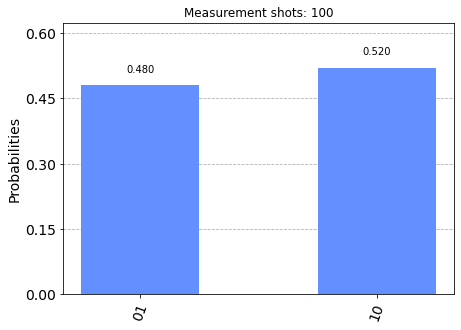

In [87]:
plot_histogram(counts[1], title="Measurement shots: 100")

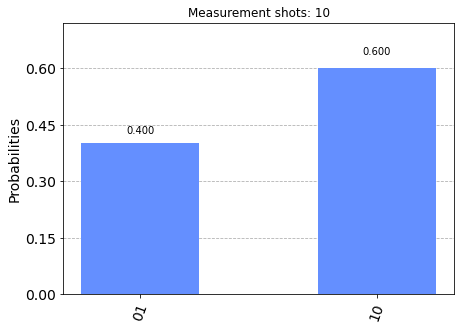

In [88]:
plot_histogram(counts[2], title="Measurement shots: 10")

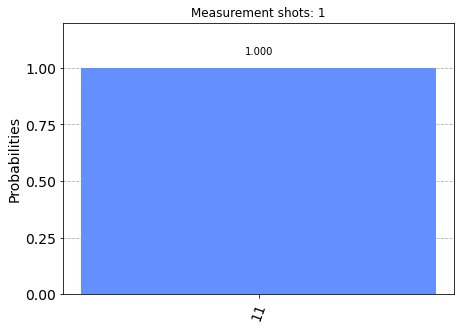

In [89]:
plot_histogram(counts[3], title="Measurement shots: 1")

### Comparing the objective function for different numbers of measurements: 1, 10, 100, 1000

We can see that as the number of shots decreases, the value of the error function increases.

**Error function**: (prob$[00]$ - 0)^2 + (prob$[01]$ - $\frac{1}{2}$)^2 + (prob$[10]$ - $\frac{1}{2}$)^2 + (prob$[11]$ - 0)^2

* prob$[00]$: probability to measure the state $|00\rangle$
* prob$[01]$: probability to measure the state $|01\rangle$
* prob$[10]$: probability to measure the state $|10\rangle$
* prob$[11]$: probability to measure the state $|11\rangle$

Text(0, 0.5, 'Error function value')

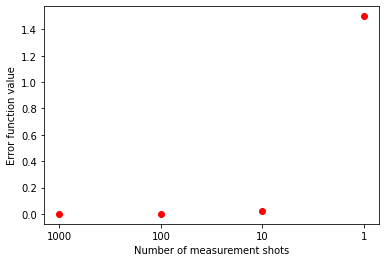

In [90]:
plt.plot(['1000', '100', '10', '1'], obj_values, 'ro')
plt.xlabel('Number of measurement shots')
plt.ylabel('Error function value')

## Conclusion:

Using gradient descent method on different parts of the circuit, we implemented a circuit which gives $|01\rangle$ and $|10\rangle$ with equal probability on a noisy simulator (```qasm_simulator```).

The histograms shows how close the probabilities of states $|01\rangle$ and $|10\rangle$ get to 0.5

The error graph shows how the error increases when the number of measurement shots are reduced.

# Bonus question solution:

For this part, in the objective fucntion, we compute the statevector of the parameterized cicuit when acted on state $|0\rangle$ and compare this statevector to the application of Hadamard gate on $|0\rangle$

**Objective function**: (statevector$[0]$.real - $\frac{1}{\sqrt{2}})^2$ + (statevector$[1]$.real - $\frac{1}{\sqrt{2}})^2$

* statevector$[0]$.real: Compute the statevector and get the real part of start $|0\rangle$
* statevector$[1]$.real: Compute the statevector and get the real part of start $|1\rangle$

For a perfect Hadamard gate, the value of this objective function would be 0

In [96]:
def objective_function_for_H_gate(params, shots=None):
    circuit = QuantumCircuit(1)
    
    circuit.ry(params[0],0)
    circuit.rx(params[1],0)

    statevector = get_state_vector(circuit)
    obj_val = ((float(statevector[0].real) - (1/2)**(1/2))**2 + (float(statevector[1].real) - (1/2)**(1/2))**2)
    return obj_val


number_of_gates = 2
initial_params = set_up_initial_params(number_of_gates)
print("Initial param: ", initial_params)


h_gate_result = perform_gradient_descent(
    initial_params, objective_function_for_H_gate)

Initial param:  [5.962015693883277, 6.099328414495149]
Number of iterations:  1000
Minimum distance:  1.4600098541679111e-06 Value of parameter:  [1.5682965388 6.0241874482]
_________________________________________________________


### Presenting results for bonus question:

In [97]:
def checking_results(x_gate_results, h_gate_result):
    """
    This function takes all the paramters we obtain from the gradient descent for 
    X gate and H gate and applies to a new circuit.
    
    We then measure this new circuit with different measurement shots
    """

    circuit = QuantumCircuit(2)

    # X gate on qubit 1
    circuit.ry(x_gate_results[0]['min_params'][0],1)

    # H gate on qubit 0
    circuit.ry(h_gate_result['min_params'][0],0)
    circuit.rx(h_gate_result['min_params'][1],0)

    # CNOT gate with qubit 0 as a control qubit and qubit 1 as the targer qubit
    circuit.cx(0,1)
    statevector = get_state_vector(circuit)
    
    return statevector

statevector = checking_results(x_gate_results, h_gate_result)
print("Resulting statevector: ", statevector)

Resulting statevector:  [-0.0070424136+0.0000000000e+00j  0.7062168463+4.5213904684e-04j
  0.7079255678+0.0000000000e+00j -0.0070254153-4.4978600958e-06j]


The state vector being produced is close to $\frac{1}{\sqrt{2}}(|01\rangle$ + $|10\rangle)$ 

**Hence we can make sure that state $|01\rangle$ + $|10\rangle$ is being produced and not $|01\rangle$ - $|10\rangle$ using a different objective function which checks the statevector of the circuit**

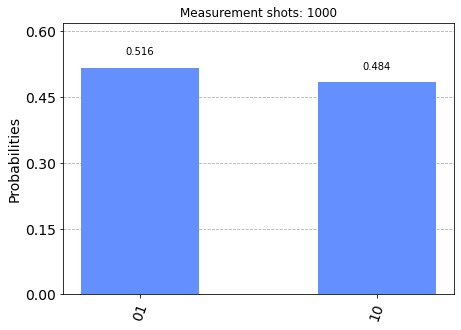

In [100]:
circuit = QuantumCircuit(2)

# X gate on qubit 1
circuit.ry(x_gate_results[0]['min_params'][0],1)

# H gate on qubit 0
circuit.ry(h_gate_result['min_params'][0],0)
circuit.rx(h_gate_result['min_params'][1],0)

# CNOT gate with qubit 0 as a control qubit and qubit 1 as the targer qubit
circuit.cx(0,1)

count = get_measurement_results(circuit, 1000)
plot_histogram(count, title="Measurement shots: 1000")